In [ ]:
# ! pip install optuna


# **Example of Optuna**

In [ ]:
def Objective(trial):
  x = trial.suggest_float('x', -10, 10)
  return (x-2)**2      

In [ ]:
study = optuna.create_study()
study.optimize(Objective, n_trials=100)

[I 2022-08-27 05:07:32,297] A new study created in memory with name: no-name-3de2894f-cb7a-4d48-ac2b-e07419510377
[I 2022-08-27 05:07:32,308] Trial 0 finished with value: 45.9775927970786 and parameters: {'x': 8.780677900997702}. Best is trial 0 with value: 45.9775927970786.
[I 2022-08-27 05:07:32,319] Trial 1 finished with value: 9.35035487412679 and parameters: {'x': -1.0578349978582544}. Best is trial 1 with value: 9.35035487412679.
[I 2022-08-27 05:07:32,322] Trial 2 finished with value: 3.7521416691890086 and parameters: {'x': 0.06295542921981045}. Best is trial 2 with value: 3.7521416691890086.
[I 2022-08-27 05:07:32,326] Trial 3 finished with value: 1.918499067788401 and parameters: {'x': 0.6149010620939741}. Best is trial 3 with value: 1.918499067788401.
[I 2022-08-27 05:07:32,329] Trial 4 finished with value: 55.82390334956517 and parameters: {'x': 9.47153955684939}. Best is trial 3 with value: 1.918499067788401.
[I 2022-08-27 05:07:32,333] Trial 5 finished with value: 71.2224

In [ ]:
best_params = study.best_params
found_x = best_params["x"]
print("Found x: {}, (x - 2)^2: {}".format(found_x, (found_x - 2) ** 2))

Found x: 2.0124018211460877, (x - 2)^2: 0.00015380516773954745


In [ ]:
study.best_value

0.00015380516773954745

In [ ]:
study.best_trial

FrozenTrial(number=91, values=[0.00015380516773954745], datetime_start=datetime.datetime(2022, 8, 27, 5, 7, 33, 204343), datetime_complete=datetime.datetime(2022, 8, 27, 5, 7, 33, 211140), params={'x': 2.0124018211460877}, distributions={'x': UniformDistribution(high=10.0, low=-10.0)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=91, state=TrialState.COMPLETE, value=None)

# **Second Example Of Optuna**

In [ ]:
"""
Optuna example that optimizes multi-layer perceptrons using PyTorch.
In this example, we optimize the validation accuracy of fashion product recognition using
PyTorch and FashionMNIST. We optimize the neural network architecture as well as the optimizer
configuration. As it is too time consuming to use the whole FashionMNIST dataset,
we here use a small subset of it.
"""

import os

import optuna
from optuna.trial import TrialState
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torchvision import datasets
from torchvision import transforms


In [ ]:
DEVICE = torch.device("cpu")
BATCHSIZE = 128
CLASSES = 10
DIR = os.getcwd()
EPOCHS = 10
N_TRAIN_EXAMPLES = BATCHSIZE * 30
N_VALID_EXAMPLES = BATCHSIZE * 10


In [ ]:
def define_model(trial):
    # We optimize the number of layers, hidden units and dropout ratio in each layer.
    n_layers = trial.suggest_int("n_layers", 1, 3)
    layers = []

    in_features = 28 * 28
    for i in range(n_layers):
        out_features = trial.suggest_int("n_units_l{}".format(i), 4, 128)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        p = trial.suggest_float("dropout_l{}".format(i), 0.2, 0.5)
        layers.append(nn.Dropout(p))

        in_features = out_features
    layers.append(nn.Linear(in_features, CLASSES))
    layers.append(nn.LogSoftmax(dim=1))

    return nn.Sequential(*layers)


In [ ]:
def get_mnist():
    # Load FashionMNIST dataset.
    train_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST(DIR, train=True, download=True, transform=transforms.ToTensor()),
        batch_size=BATCHSIZE,
        shuffle=True,
    )
    valid_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST(DIR, train=False, transform=transforms.ToTensor()),
        batch_size=BATCHSIZE,
        shuffle=True,
    )

    return train_loader, valid_loader

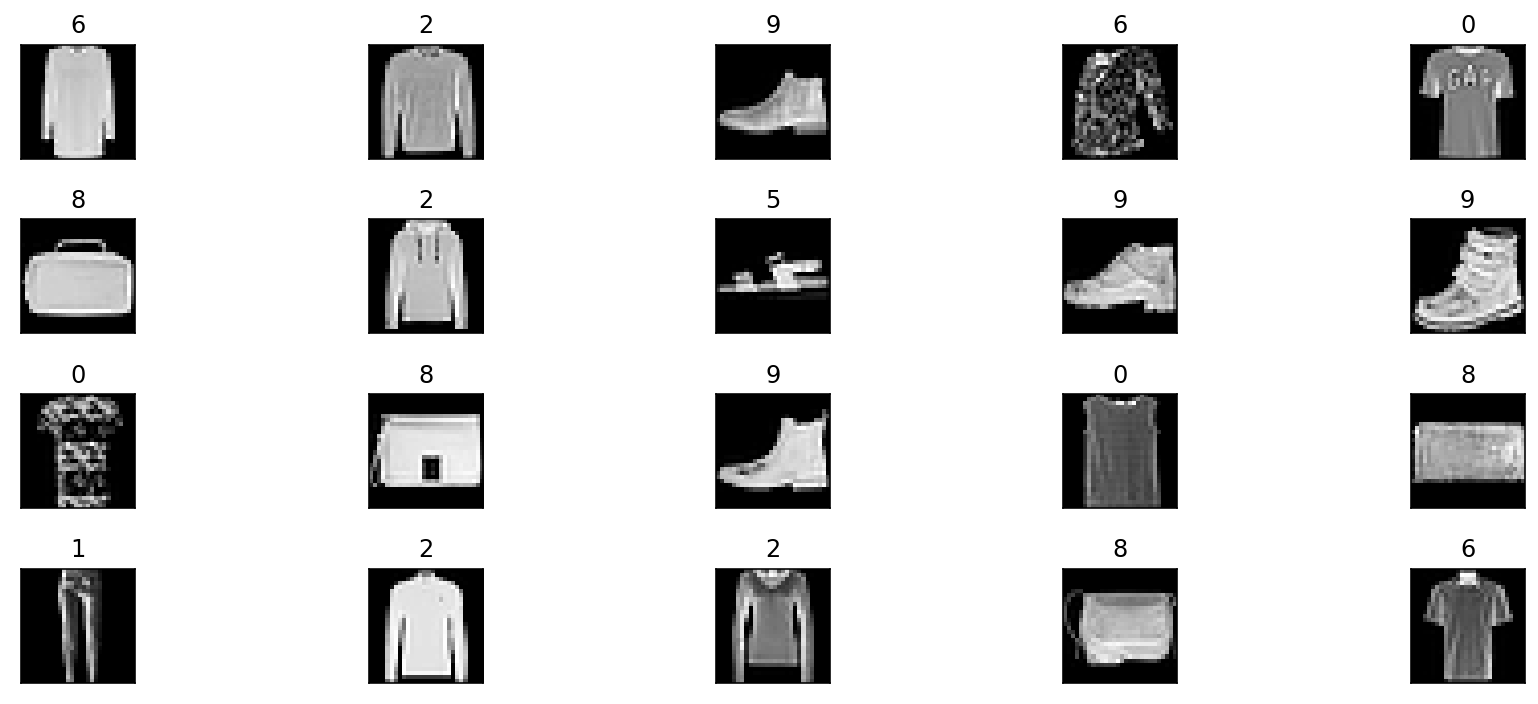

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

trainloader, testloader = get_mnist()
dataiter = iter(trainloader)
print(dataiter)
images, labels = dataiter.next()


fig = plt.figure(figsize=(15,5))
for idx in np.arange(20):
  # xticks=[], yticks=[] is empty to print the images without any ticks around them
  #np.sqeeze : Remove single-dimensional entries from the shape of an array.
  ax = fig.add_subplot(4, 20/4, idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(images[idx]), cmap='gray')
   # .item() gets the value contained in a Tensor
  ax.set_title(labels[idx].item())
  fig.tight_layout()

In [ ]:
def objective(trial):

    # Generate the model.
    model = define_model(trial).to(DEVICE)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    # Get the FashionMNIST dataset.
    train_loader, valid_loader = get_mnist()

    # Training of the model.
    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # Limiting training data for faster epochs.
            if batch_idx * BATCHSIZE >= N_TRAIN_EXAMPLES:
                break

            data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)    

            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

        # Validation of the model.
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(valid_loader):
                # Limiting validation data.
                if batch_idx * BATCHSIZE >= N_VALID_EXAMPLES:
                    break
                data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)
                output = model(data)
                # Get the index of the max log-probability.
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        accuracy = correct / min(len(valid_loader.dataset), N_VALID_EXAMPLES)

        trial.report(accuracy, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy


In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


[I 2022-08-27 07:02:51,454] A new study created in memory with name: no-name-f342ca82-a656-43ae-8619-f439c16059f4


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



[I 2022-08-27 07:03:06,179] Trial 0 finished with value: 0.4515625 and parameters: {'n_layers': 3, 'n_units_l0': 104, 'dropout_l0': 0.32993826235191437, 'n_units_l1': 20, 'dropout_l1': 0.24871674189915363, 'n_units_l2': 106, 'dropout_l2': 0.3422051836586072, 'optimizer': 'RMSprop', 'lr': 3.478474894521713e-05}. Best is trial 0 with value: 0.4515625.
[I 2022-08-27 07:03:12,232] Trial 1 finished with value: 0.74453125 and parameters: {'n_layers': 1, 'n_units_l0': 96, 'dropout_l0': 0.24079892482403215, 'optimizer': 'Adam', 'lr': 0.0466132127593357}. Best is trial 1 with value: 0.74453125.
[I 2022-08-27 07:03:17,988] Trial 2 finished with value: 0.70703125 and parameters: {'n_layers': 1, 'n_units_l0': 33, 'dropout_l0': 0.33719059915027194, 'optimizer': 'RMSprop', 'lr': 0.0002284087291538272}. Best is trial 1 with value: 0.74453125.
[I 2022-08-27 07:03:24,190] Trial 3 finished with value: 0.625 and parameters: {'n_layers': 3, 'n_units_l0': 70, 'dropout_l0': 0.22976678067570244, 'n_units_l1'

Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  61
  Number of complete trials:  39
Best trial:
  Value:  0.84453125
  Params: 
    n_layers: 1
    n_units_l0: 114
    dropout_l0: 0.24960020276845404
    optimizer: Adam
    lr: 0.0027235227773161606
